In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE


DATA PREPROCESSING

In [2]:
# Read the CSV file
train = pd.read_csv('stroketrain.csv')

# Drop null values
train.dropna(inplace=True)
train.iloc[0:10]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
5,5,Female,34.0,0,0,Yes,Private,Urban,84.35,22.2,Unknown,0
6,6,Female,53.0,0,0,Yes,Private,Rural,88.97,25.3,never smoked,0
7,7,Male,78.0,0,1,Yes,Self-employed,Rural,75.32,24.8,Unknown,0
8,8,Female,45.0,0,0,Yes,Private,Rural,107.22,34.1,never smoked,0
9,9,Female,62.0,0,0,Yes,Govt_job,Urban,62.68,18.4,formerly smoked,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


DATA EXPLORATION

In [4]:
round(100*train['stroke'].value_counts() / train.shape[0], 2)

0    95.87
1     4.13
Name: stroke, dtype: float64

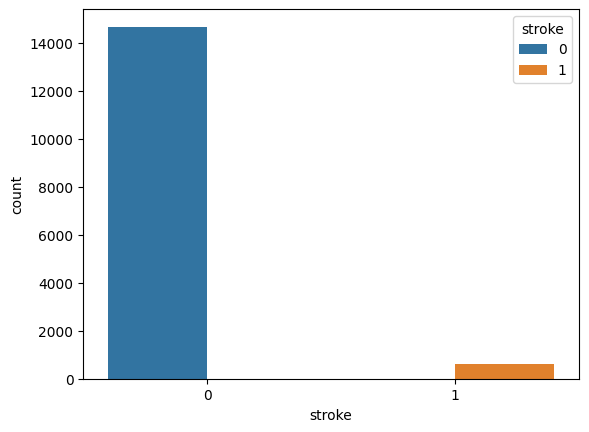

In [5]:
sns.countplot(x = 'stroke', hue = 'stroke', data = train);

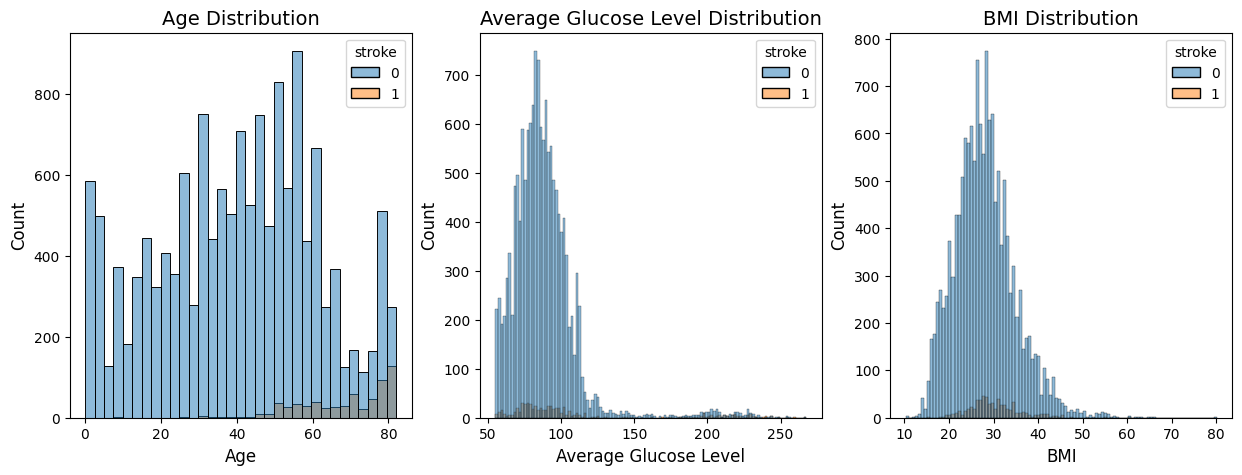

In [6]:
# Data exploration
def plot_histogram(ax, data, x_label, hue, title):
    sns.histplot(ax=ax, x=data, hue=hue, fill=True, data=train)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(title, fontsize=14)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_histogram(axes[0], 'age', 'Age', 'stroke', 'Age Distribution')
plot_histogram(axes[1], 'avg_glucose_level', 'Average Glucose Level', 'stroke', 'Average Glucose Level Distribution')
plot_histogram(axes[2], 'bmi', 'BMI', 'stroke', 'BMI Distribution')
plt.show()

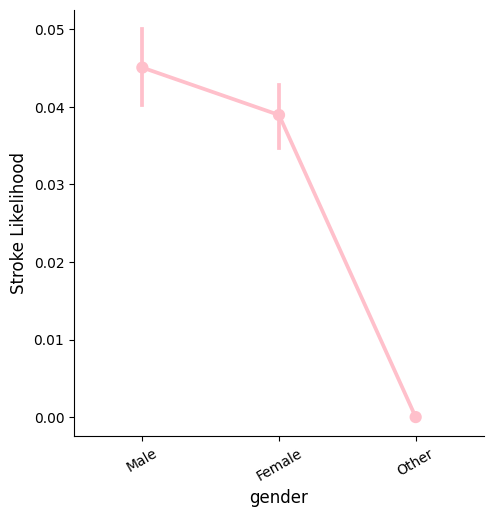

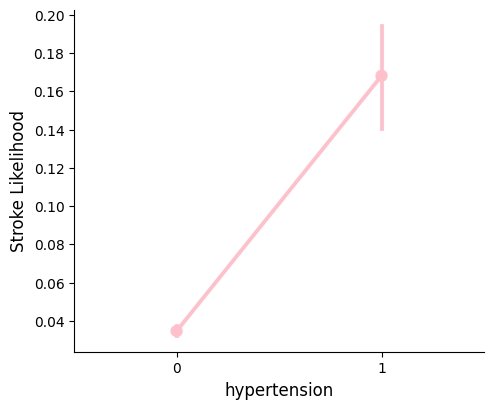

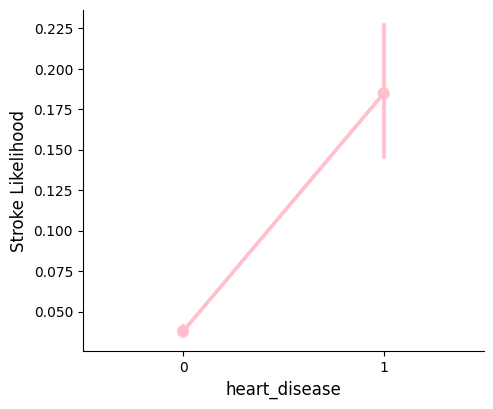

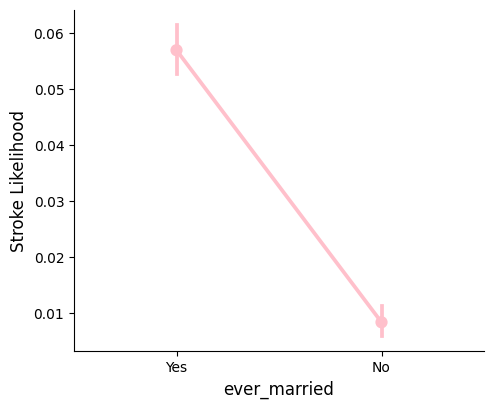

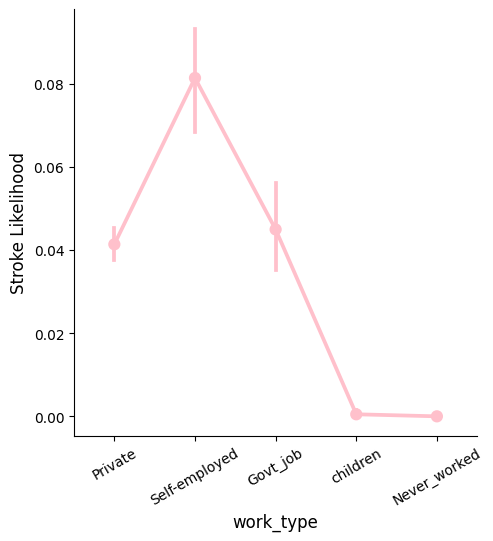

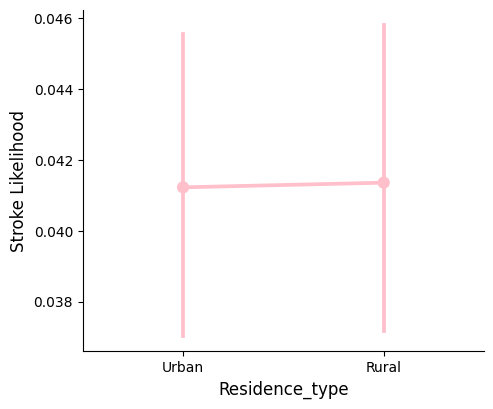

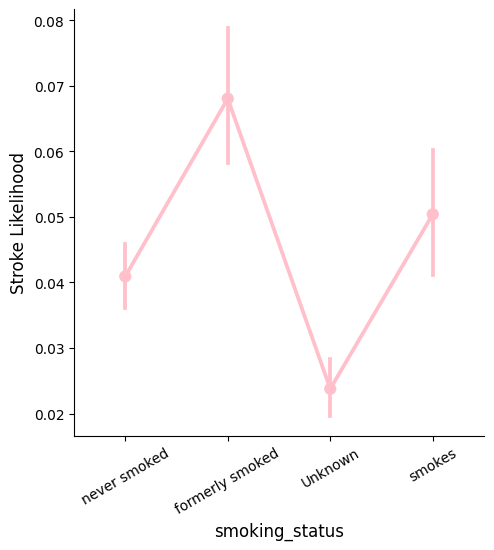

In [7]:
def plot_categorical(data, x_col, y_col):
    plot = sns.catplot(data=data, x=x_col, y=y_col, kind='point', color='pink')
    plot.set_xlabels(x_col, fontsize=12)
    plot.set_ylabels('Stroke Likelihood', fontsize=12)
    return plot

categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    plot = plot_categorical(train, col, 'stroke')
    if len(train[col].unique()) <= 2:  # Combine figures with only one row
        plot.fig.subplots_adjust(top=0.8)  # Adjust the top margin for combined figures
    else:
        plot.set_xticklabels(rotation=30)
plt.show()

In [8]:
# Encode categorical columns
le_dict = {}
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        le_dict[col] = le
train.iloc[0:10]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1,28.0,0,0,1,2,1,79.53,31.1,2,0
1,1,1,33.0,0,0,1,2,0,78.44,23.9,1,0
2,2,0,42.0,0,0,1,2,0,103.00,40.3,0,0
3,3,1,56.0,0,0,1,2,1,64.87,28.8,2,0
4,4,0,24.0,0,0,0,2,0,73.36,28.8,2,0
5,5,0,34.0,0,0,1,2,1,84.35,22.2,0,0
6,6,0,53.0,0,0,1,2,0,88.97,25.3,2,0
7,7,1,78.0,0,1,1,3,0,75.32,24.8,0,0
8,8,0,45.0,0,0,1,2,0,107.22,34.1,2,0
9,9,0,62.0,0,0,1,0,1,62.68,18.4,1,0


In [9]:
# Data preparation
X = train.drop(columns=['stroke'])
Y = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [10]:
# Resampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

MODELLING

In [11]:
# Calculate class weights for cost-sensitive learning
weights = class_weight.compute_sample_weight(class_weight='balanced', y=Y_train_resampled)

In [12]:
# Define base models
rf_base = RandomForestClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300, class_weight='balanced', random_state=42)
lr_base = LogisticRegression(C=0.2, penalty='l1', solver='saga', max_iter=10000, class_weight='balanced', random_state=42)
gb_base = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=5, min_samples_split=10, subsample=0.8, random_state=42)

In [13]:
# Train the Gradient Boosting model with sample weights for cost-sensitive learning
gb_base.fit(X_train_resampled, Y_train_resampled, sample_weight=weights)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                           min_samples_split=10, n_estimators=500,
                           random_state=42, subsample=0.8)

In [14]:
# Define bagging classifiers
bagged_RF = BaggingClassifier(base_estimator=rf_base, n_estimators=5, random_state=42)
bagged_LR = BaggingClassifier(base_estimator=lr_base, n_estimators=5, random_state=42)
bagged_GB = BaggingClassifier(base_estimator=gb_base, n_estimators=5, random_state=42)

In [15]:
# Cross-validation and training for each base model
def cross_validate_and_train(bagged_model, X, Y):
    cv_scores, roc_auc_scores = [], []
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        bagged_model.fit(X_train, Y_train)
        preds = bagged_model.predict_proba(X_test)[:, 1]
        roc_auc_scores.append(roc_auc_score(Y_test, preds))
    cv_scores.append(np.mean(roc_auc_scores))
    return np.mean(cv_scores)


In [16]:
rf_cv_score = cross_validate_and_train(bagged_RF, X, Y)
lr_cv_score = cross_validate_and_train(bagged_LR, X, Y)
gb_cv_score = cross_validate_and_train(bagged_GB, X, Y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

In [17]:
# Display CV scores
print('Random Forest Bagged ROC-AUC:', rf_cv_score)
print('Logistic Regression Bagged ROC-AUC:', lr_cv_score)
print('Gradient Boosting Bagged ROC-AUC:', gb_cv_score)

Random Forest Bagged ROC-AUC: 0.8749394338755062
Logistic Regression Bagged ROC-AUC: 0.8334567555191464
Gradient Boosting Bagged ROC-AUC: 0.8846373212808654


In [18]:
# Making predictions on the entire train dataset for each model
bagged_RF.fit(X, Y)
train_preds_RF = pd.DataFrame({'stroke': Y, 'stroke_pred': bagged_RF.predict_proba(X)[:, 1]})
train_preds_RF.head()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,stroke,stroke_pred
0,0,0.132983
1,0,0.120052
2,0,0.217403
3,0,0.436786
4,0,0.042612


In [19]:
bagged_LR.fit(X, Y)
train_preds_LR = pd.DataFrame({'stroke': Y, 'stroke_pred': bagged_LR.predict_proba(X)[:, 1]})
train_preds_LR.head()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,stroke,stroke_pred
0,0,0.206846
1,0,0.476581
2,0,0.224413
3,0,0.745181
4,0,0.199057


In [20]:
bagged_GB.fit(X, Y)
train_preds_GB = pd.DataFrame({'stroke': Y, 'stroke_pred': bagged_GB.predict_proba(X)[:, 1]})
train_preds_GB.head()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,stroke,stroke_pred
0,0,0.004654
1,0,0.003597
2,0,0.010213
3,0,0.043011
4,0,0.003771


In [21]:
# Plot ROC curves for each bagged classifier
def plot_roc_curve(train_preds, title):
    RocCurveDisplay.from_predictions(train_preds['stroke'], train_preds['stroke_pred'])
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

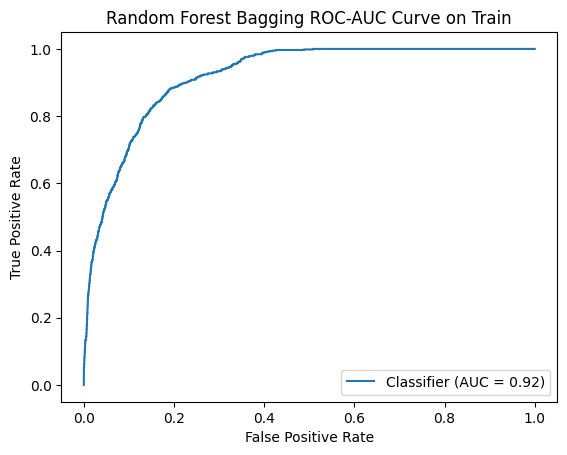

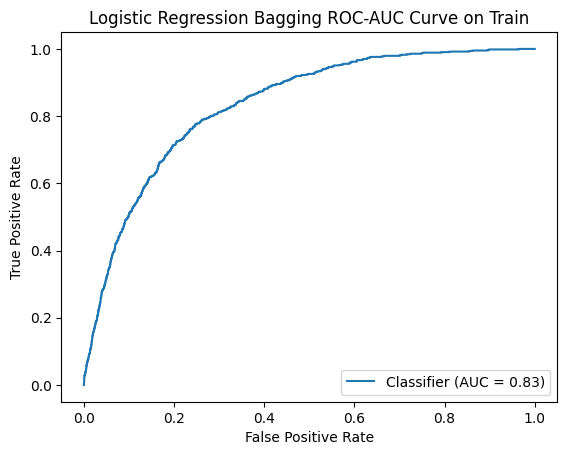

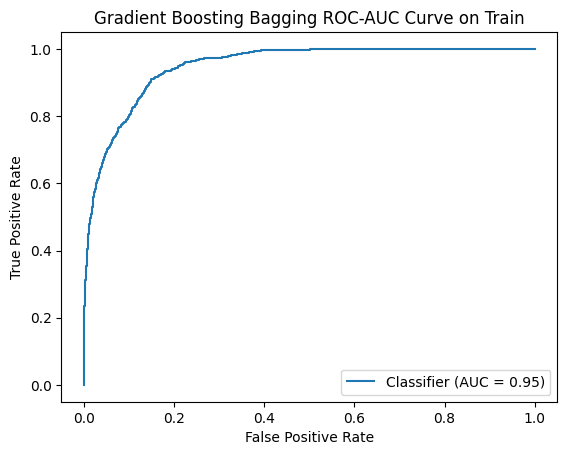

In [22]:
plot_roc_curve(train_preds_RF, 'Random Forest Bagging ROC-AUC Curve on Train')
plot_roc_curve(train_preds_LR, 'Logistic Regression Bagging ROC-AUC Curve on Train')
plot_roc_curve(train_preds_GB, 'Gradient Boosting Bagging ROC-AUC Curve on Train')

COMBINATION OF ALL 4 MODELS


In [23]:
# Combine predictions from all models for the test set
ensemble_predictions = (bagged_RF.predict_proba(X_test)[:, 1] +
                        bagged_LR.predict_proba(X_test)[:, 1] +
                        bagged_GB.predict_proba(X_test)[:, 1]) / 3

In [24]:
# Create a DataFrame with the ensemble predictions
df_ensemble_predictions = pd.DataFrame({'Ensemble_Predicted': ensemble_predictions})

# Show the actual values and ensemble predictions
df_combined_predictions = pd.concat([pd.DataFrame({'Actual': Y}), df_ensemble_predictions], axis=1)
print('Combined Predictions:\n', df_combined_predictions)

Combined Predictions:
        Actual  Ensemble_Predicted
0           0            0.039780
1           0            0.239969
2           0            0.242036
3           0            0.134344
4           0            0.334176
...       ...                 ...
15299       0                 NaN
15300       0                 NaN
15301       0                 NaN
15302       0                 NaN
15303       0                 NaN

[15304 rows x 2 columns]


In [25]:
# ROC AUC Calculation
fpr, tpr, _ = roc_curve(Y_test, ensemble_predictions)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC Score: {roc_auc}')


ROC AUC Score: 0.9125869354119099


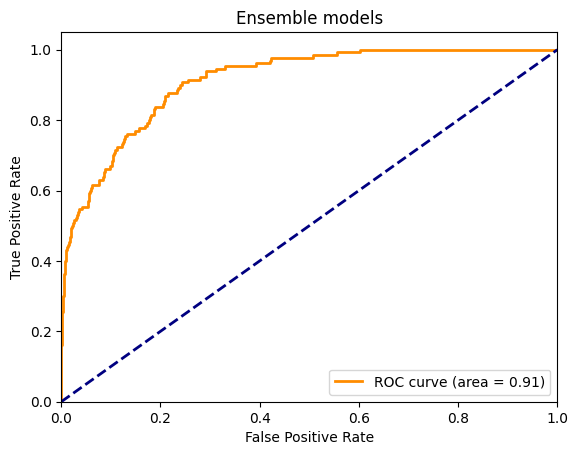

In [26]:
# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble models')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Find Optimal Threshold
precisions, recalls, thresholds = precision_recall_curve(Y_test, ensemble_predictions)
optimal_idx = np.argmax(np.sqrt(recalls * precisions))
optimal_threshold = thresholds[optimal_idx]

ensemble_class_labels = np.where(ensemble_predictions > optimal_threshold, 1, 0)

In [28]:
# Evaluate the model
precision = precision_score(Y_test, ensemble_class_labels)
recall = recall_score(Y_test, ensemble_class_labels)
f1 = f1_score(Y_test, ensemble_class_labels)
accuracy = accuracy_score(Y_test, ensemble_class_labels)

# Display results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.6547619047619048
Recall: 0.4230769230769231
F1-Score: 0.5140186915887851
Accuracy: 0.9660241751061744


In [29]:
# Confusion Matrix
cm = confusion_matrix(Y_test, ensemble_class_labels)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[2902   29]
 [  75   55]]


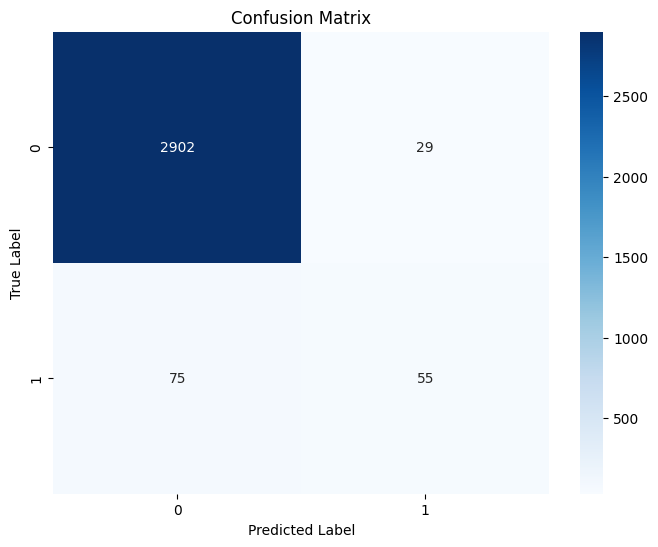

In [30]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.base import BaseEstimator

class EnsembleModel(BaseEstimator):
    def __init__(self, models):
        self.models = models  # A list of the individual models

    def fit(self, X, y):
        # Fit each of the models on the data
        for model in self.models:
            model.fit(X, y)
        return self

    def predict_proba(self, X):
        # Averaging the predict_proba of each of the models
        predictions = [model.predict_proba(X)[:, 1] for model in self.models]
        return np.mean(predictions, axis=0)

    def predict(self, X):
        # Convert probabilities to final predictions
        probabilities = self.predict_proba(X)
        return np.where(probabilities > 0.5, 1, 0)  # Using 0.5 as threshold for binary classification

# Example of creating and saving the ensemble model
ensemble_model = EnsembleModel(models=[bagged_RF, bagged_LR, bagged_GB])


SAVING USING JOBLIB

In [32]:
# Save the scaler to a file
with open('scalers.pkl', 'wb') as f:
    joblib.dump(scaler, f)

In [33]:
# Save the ensemble model using joblib
with open('ensemble_models.pkl', 'wb') as f:
    joblib.dump(ensemble_model, f)